<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/DLL30_DZ2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Многослойная нейронная сеть»

Преподаватель: Даниил Корбут, Алексей Миронов, Юлия Пономарева, Татьяна Булгакова, Светлана Медведева, Артём Качалкин

Цель задания: научиться на простейшем уровне подбирать архитектуру полносвязной нейронной сети для получения качества решения задачи не ниже заданного.

Задание
Постройте модель на основе полносвязных слоёв для классификации Fashion MNIST из библиотеки torchvision (datasets).
Получите качество на тестовой выборке не ниже 88%

*Инструкция по выполнению задания*

1. Скачайте тренировочную и тестовою часть датасета Fashion MNIST

2. Постройте модель, выбрав стартовую архитектуру

3. Обучите модель и сверьте качество на тестовой части с заданным порогом

Изменяйте архитектуру модели, пока качество на тестовой части не будет выше порога. Вариации архитектуры можно реализовать через изменение количества слоёв, количества нейронов в слоях и использование регуляризации.
Можно использовать различные оптимизаторы


# 0. Импорт библиотек и пользовательские функции

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import time

In [2]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [9]:
device ='cuda' if torch.cuda.is_available else 'cpu'
print(f'Using {device} device')

Using cuda device


# 1. Загрузка данных

In [3]:
train_set = tv.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = tv.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 18915687.82it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 301240.01it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5613597.38it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9164803.48it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [27]:
train_set[0][0].shape

torch.Size([1, 28, 28])

In [19]:
THRESHOLD = 0.88
BATCH_SIZE=32

## 1.1. Визуализация

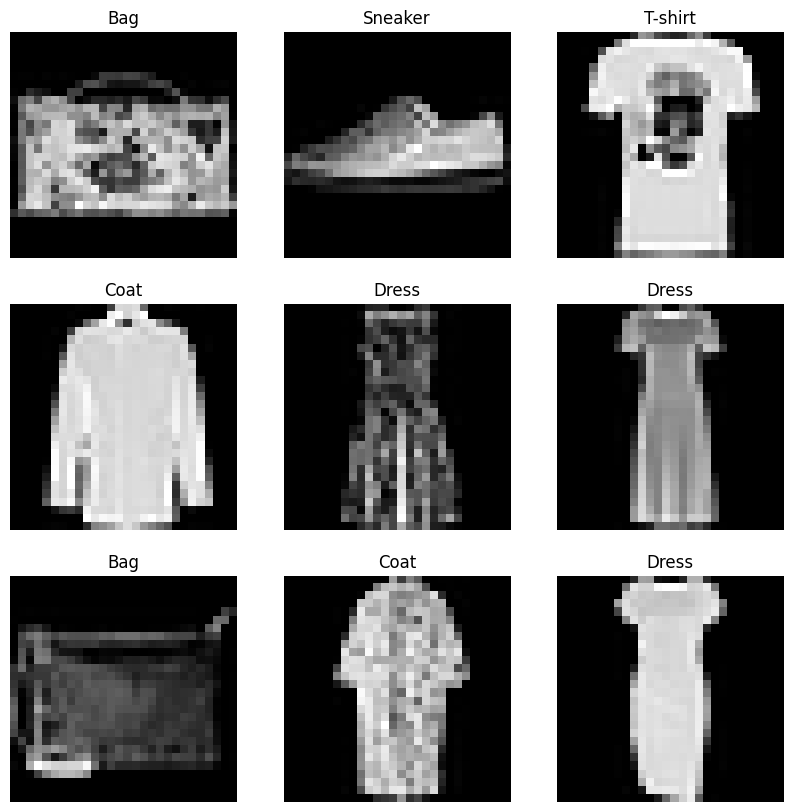

In [7]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_set), size = (1,)).item()
    image, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

## 1.2. Загрузчика данных pytorch для train и test

In [20]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=BATCH_SIZE)

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) <built-in method type of Tensor object at 0x780c8a1b1170>


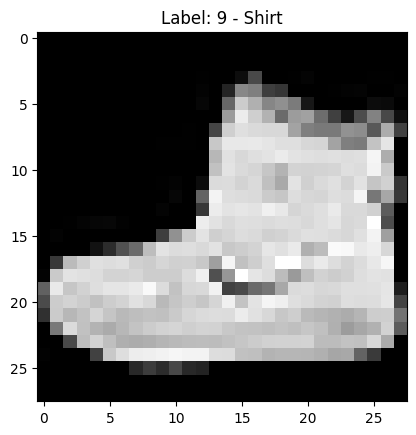

Labels batch shape: torch.Size([32])


In [21]:
for X,y in train_loader:
    train_features, train_labels = next(iter(train_loader))
    print(f'Shape of X [N, C, H, W]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.type}')
    image = train_features[0].squeeze()
    label = train_labels[0]
    sample_idx= torch.randint((label), size = (1,)).item()
    plt.title(f"Label: {label} - {labels_map[sample_idx]}")
    plt.imshow(image, cmap="gray")
    plt.show()
    print(f"Labels batch shape: {train_labels.size()}")
    break

# Выбор базовой архитектуры

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [22]:
# У меня нет GPU, поэтому буду использовать CPU
device = 'cpu'
model = NeuralNetwork().to(device)

In [28]:
# Гиперпараметры  базовой модели
learning_rate = 1e-3
epochs = 10

# Ф-я потерь
loss_fn = nn.CrossEntropyLoss()

#Оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [24]:
def trainloop (dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)

        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')

In [31]:
def evaluate (dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    return 100 * correct, test_loss

In [32]:
accuracy_max = 0
test_loss_opt = 0
epoch_opt = 1
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    trainloop(train_loader, model, loss_fn, optimizer)
    accuracy, test_loss = evaluate(test_loader, model, loss_fn)
    if accuracy > accuracy_max:
      accuracy_max = accuracy
      test_loss_opt = test_loss
      epoch_opt = i
print("Done!")

Epoch 1
-------------------------------
loss:0.433298 [    0/60000]
loss:0.677163 [ 3200/60000]
loss:0.415865 [ 6400/60000]
loss:0.553794 [ 9600/60000]
loss:0.427793 [12800/60000]
loss:0.767316 [16000/60000]
loss:0.415906 [19200/60000]
loss:0.252316 [22400/60000]
loss:0.485107 [25600/60000]
loss:0.657219 [28800/60000]
loss:0.567474 [32000/60000]
loss:0.441448 [35200/60000]
loss:0.654961 [38400/60000]
loss:0.755548 [41600/60000]
loss:0.724303 [44800/60000]
loss:0.454101 [48000/60000]
loss:0.561170 [51200/60000]
loss:0.617880 [54400/60000]
loss:0.547465 [57600/60000]
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.536722 

Epoch 2
-------------------------------
loss:0.424585 [    0/60000]
loss:0.670215 [ 3200/60000]
loss:0.403433 [ 6400/60000]
loss:0.542670 [ 9600/60000]
loss:0.418540 [12800/60000]
loss:0.763126 [16000/60000]
loss:0.409429 [19200/60000]
loss:0.241918 [22400/60000]
loss:0.475081 [25600/60000]
loss:0.638877 [28800/60000]
loss:0.558563 [32000/60000]
loss:0.437006 [35200/60000]


In [33]:
print(accuracy_max, test_loss_opt, epoch_opt)

82.53 0.4889414771296346 9


In [ ]:
df_results= pd.DataFrame(columns = ['optimizer', 'accuracy', 'avg_loss', 'epoch'])
df_results.loc[len(df_results.index)] = ['SGD',  accuracy_max, test_loss_opt, epoch_opt]

Вывод:
Качество базовой модели не достигло заданного порога за 10 эпох. При этом с увеличением числа эпох обучения качество растет, но чем дальше, тем медленнее, и скорее всего, при базовых настройках для преодоления порога в 88%  либо потребуется не менее 60 эпох, либо он вовсе не будет преодолен.

Планирую следующую стратегию:

1. Вначале проверю, как изменится качество модели при использовании других оптимизаторов с сохранением прочих гиперпараметров (числа эпох, шага обучения, размера батча, к-ва слоев, ширины промежуточного слоя). Если порог не будет преодолен, то
2. Использую лучший оптимизатор из п. 1 и буду увеличивать ширину промежуточного слоя. Если порог все еще не будет преодолен, При достижении переобучения добавлю Dropout

In [40]:
optimizers = []
# optimizers.append({"SGD": torch.optim.SGD(model.parameters(), lr=learning_rate)})
optimizers.append({"RMSProp": torch.optim.RMSprop(model.parameters(), lr=learning_rate)})
optimizers.append({"AdamW": torch.optim.AdamW(model.parameters(), lr=learning_rate)})
optimizers.append({"Adagrad": torch.optim.Adagrad(model.parameters(), lr=learning_rate)})
optimizers.append({"NADam": torch.optim.NAdam(model.parameters(), lr=learning_rate)})

In [ ]:
for optimizer in optimizers:
  for key, value in optimizer.items():
    accuracy_max = 0
    test_loss_opt = 0
    epoch_opt = 1
    for i in range(epochs):
        print(f"Epoch {i+1}\n-------------------------------")
        trainloop(train_loader, model, loss_fn, value)
        accuracy, test_loss = evaluate(test_loader, model, loss_fn)
        if accuracy > accuracy_max:
          accuracy_max = accuracy
          test_loss_opt = test_loss
          epoch_opt = i
    print("Done!")
    df_results.loc[len(df_results.index)] = [key,  accuracy_max, test_loss_opt, epoch_opt]

Epoch 1
-------------------------------
loss:0.360566 [    0/60000]
loss:0.808664 [ 3200/60000]
loss:0.389809 [ 6400/60000]
loss:0.711804 [ 9600/60000]
loss:0.476984 [12800/60000]
loss:1.000365 [16000/60000]
loss:0.402195 [19200/60000]
loss:0.377809 [22400/60000]
loss:0.503165 [25600/60000]
loss:0.402672 [28800/60000]
loss:0.494394 [32000/60000]
loss:0.500184 [35200/60000]
loss:0.372076 [38400/60000]
loss:0.513528 [41600/60000]
loss:0.781536 [44800/60000]
loss:0.419188 [48000/60000]
loss:0.480266 [51200/60000]
loss:0.383138 [54400/60000]
loss:0.596506 [57600/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.420151 

Epoch 2
-------------------------------
loss:0.305377 [    0/60000]
loss:0.428643 [ 3200/60000]
loss:0.198034 [ 6400/60000]
loss:0.436206 [ 9600/60000]
loss:0.319884 [12800/60000]
loss:0.782833 [16000/60000]
loss:0.321736 [19200/60000]
loss:0.206609 [22400/60000]
loss:0.371317 [25600/60000]
loss:0.242128 [28800/60000]
loss:0.466811 [32000/60000]
loss:0.405396 [35200/60000]


In [ ]:
df_results.sort_values(by='r2score', ascending=False)